# Meditation and Neural Activities: Replication & Classifier Development
**Final Data Science Neuroscience Project**<br>
A replication of Brandmeyer & Delorme (2018), with data-driven techniques. Creating new logistic regression model for classifer of expert vs. non-expert in mediation.

**Yuyang Zhong**<br>
University of California, Berkeley<br>
December 9, 2019

**Cognitive Neuroscience**<br>
Jack L. Gallant, Ph.D., *Professor*<br>
Manon Ironside, *Graduate Student Instructor*

----

## Introduction

### Background
Meditation had been claim to have a lot of physical and mental effects for individuals who actively practice meditation on a regular basis. However, to psychologists and neuroscientists, reserachers are more interested in how these effects show up. Past research had focused on whether there was significant changes in subjects' neural activities when engaged in meditation over a period of time. 

The current research that this project is based on, conducted by Brandmeyer & Delorme in 2016, focuses on whether there was a significant difference in depth and neural activity (measured through EEG) for those who practice meditation on a more frequent basis (expert) compared to those on a less frequent basis (non-expert). 

This project will dive into understanding the published data better, and see if a classifier could be built to label expert vs. non-expert based on neural activities during meditation. 

### Motivation & Significance
In the literature, probe into meditation had lead researcherse to find evidence of a Default-mode Network, as well as differences in functional connectivity of brain activities (Berkovich-Ohana et al. 2016;, Garrison et al. 2015). 

The present research (Brandmeyer & Delorme 2016), as well as this project, can potentially provide evidence for whether meditation alters one's default-mode network and functional connectivity, and attributing those change in neural activities to the benefits claimed by individuals practicing meditation as part of their daily lives. Authors of this paper were also trying to probe whether default mode network was related to the frequency of mind wandering episodes during meditation, especialy those not aware by the individual (Christoff et al. 2009).

## Method

### Dataset Overview
This dataset was made available by the authors of the present research (Brandmeyer & Delorme 2016), at multiple open data repositories. Version 2.0 of the data, published on November 19, 2018, was downloaded from **Zenodo** (https://doi.org/10.5281/zenodo.2536267).

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2536267.svg)](https://doi.org/10.5281/zenodo.2536267)

#### Description by Author
This meditation experiment contains 24 subjects. Subjects were meditating and were interrupted about every 2 minutes to indicate their level of concentration and mind wandering.

#### Dataset organization
The dataset is organized in the BIDS format. The raw data contains the MATLAB code for session, sound files to the stimuli, folders for each subject, within with folders for each session the subject participated in. In the session folders the eeg measures and event files are provided.

### Methods & Techniques
(Section referenced and adopted from original research article.)

Data was collected via EEG, using a 64-channel Biosemi system and and Biosemi 10-20 head cap montage. There are a total of 64 channels (locations of measure), mapped by the `Biosemi64Alpha` montage (not part of the standard `mne` pakages, direction to load included below). This measure has very well temporal resolution but poor spatial resolution.

A total of 24 participants were in this study. Participants were asked to meditate for 30-90 seconds, and interrupted to rate their mindfulness depth and mind wondering level. This project will solely focus on the onset of that interruption, and the period of medidation before that. 

## Data Analysis

### Outline of Analysis
The following table summarizes the techniques used in each section.

| Section | Methods | Motivation |
| ------- | ------- | ---------- |
| **Data Exploration** | Time frequency analysis | Compute Time-Frequency Representation (TFR) using Morlet wavelet, and seeing if I can identify concentrations of epoches to focus on. |
| **Data Exploration** | Topographic Mapping: All Evoked Response | Looking at average brain activities near an event. |
| **Data Exploration** | Event-related Spectral Pertubation (ERSP): Onset Evoked Response | This would be important to help us understand whether this question is actually valid to ask - is there a difference in onset evoked response, and activities before that between the 2 subject groups? | 
| **Data Cleaning** | - | The data will be shrinked down to an average of all evoked responses, 10 seconds before the onset and 5 after, for each individual subjects. This will be used for the classifier. | 
| **Data Analysis** | Correlation Matrix | Looking at which channels are most and least correlated with each other. |
| **Data Analysis** | Independent Component Analysis (ICA) & Principal Component Analysis (PCA) | Looking at which channels are most significant in contribution to the overall brain activity, and try to see if I can figure out why. This would help identify components to use for our model. |
| **Classifier** | Logistic Regression | The simplier method. | 
| **Classifier** | Neural Network | A bit fancier method to improve accuracy. |
| **Classifier** | Random Forest | A bit fancier method to improve accuracy. |

### Project Setup & Imports

#### Project Dependencies
This project utilizes the following Python packages:
`numpy`,
`pandas`,
`matplotlib`,
`seaborn`,
`mne`, and
`sklearn`.

To install a package within this jupyter notebook, utilize the command `!pip install [package-name]`. The `!` will allow you to run command line prompt within this notebook.

#### Importing Packages

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import mne

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#### Supresses Warnings
This is used for exporting the final PDF file. Feel free to comment this out.

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Exploration on Subject 1 (Non-Expert) & 15 (Expert)

#### Importing data
**Assuming your currently directory is in the `notebook` folder. <br>**
Remove `../` in the file paths if your working directory is in the top level of this project.

In [3]:
raw_fname1 = '../rawdata/bidsexport/sub-001/ses-01/eeg/sub-001_ses-01_task-meditation_eeg.bdf'
raw_fname15 = '../rawdata/bidsexport/sub-015/ses-01/eeg/sub-015_ses-01_task-meditation_eeg.bdf'

raw1 = mne.io.read_raw_bdf(raw_fname1, preload=True)
raw15 = mne.io.read_raw_bdf(raw_fname15, preload=True)

Extracting EDF parameters from /Users/yuyang.zhong/eeg/rawdata/bidsexport/sub-001/ses-01/eeg/sub-001_ses-01_task-meditation_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696575  =      0.000 ...  2720.996 secs...
Extracting EDF parameters from /Users/yuyang.zhong/eeg/rawdata/bidsexport/sub-015/ses-01/eeg/sub-015_ses-01_task-meditation_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 695807  =      0.000 ...  2717.996 secs...


For the purpose of this project, we will remove all of the channels that are metadata of the subject/experiment. We are focusing only on the 64 channels measuring EEG activities.

In [4]:
raw1.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 
                   'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])
raw15.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 
                   'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])

<RawEDF  |  sub-015_ses-01_task-meditation_eeg.bdf, n_channels x n_times : 65 x 695808 (2718.0 sec), ~345.2 MB, data loaded>

#### Loading & setting custom montage `biosemi64alpha`

Since the researchers used an Alphabetical (A/B) version of the standard `biosemi64` montage, we will need to load our own montage file to allow appropriate topographical mapping. 

In [5]:
from os.path import abspath
montage = mne.channels.read_montage(abspath("../biosemi64alpha.txt"))

raw1.set_montage(montage);
raw15.set_montage(montage);

#### Subject Information
Let's print 1 subject's EEG information.

In [6]:
print(raw1)
print(raw1.info)

<RawEDF  |  sub-001_ses-01_task-meditation_eeg.bdf, n_channels x n_times : 65 x 696576 (2721.0 sec), ~345.6 MB, data loaded>
<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | A1, A2, A3, A4, A5, A6, A7, A8, A9, ...
    chs : list | 65 items (EEG: 64, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 67 items (3 Cardinal, 64 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 52.0 Hz
    meas_date : tuple | 2014-04-04 19:40:17 GMT
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 256.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info

The location of the sensors/channels are shown below. As you can see, the labels of the channels begin with A & B as aligned with the left/right hemispheres, instead of the specific naming of the standard BioSemi64 channel names.

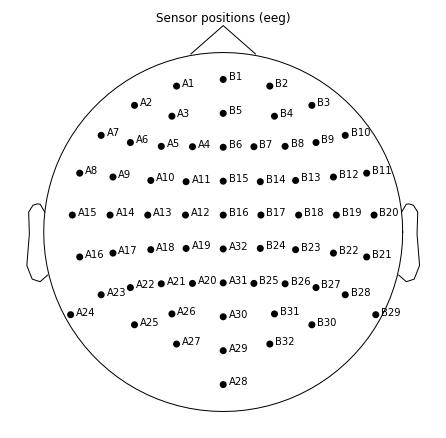

In [7]:
mne.viz.plot_sensors(raw1.info, ch_type='eeg', show_names=True);

#### Events & Epoches
What kind of events are there in this session? This prints the top 5 events found for subject 1.

In [8]:
events1 = mne.find_events(raw1, stim_channel='Status')
events15 = mne.find_events(raw15, stim_channel='Status')
print(events1[:5])
print(events15[:5])

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
87 events found
Event IDs: [  2   4 128]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
84 events found
Event IDs: [  2   4 128]
[[18275     0   128]
 [19387     0     2]
 [20422     0     2]
 [32156     0   128]
 [46029     0   128]]
[[35569     0   128]
 [36506     0     2]
 [37545     0     4]
 [69254     0   128]
 [70197     0     4]]


From the `task-meditation_events.json` file, we found the following ID corresponding the events.

In [9]:
import json
with open("../rawdata/bidsexport/task-meditation_events.json", "r") as events_file:
    events = json.load(events_file)

event_dict = {i: d for d, i in events['value']['Levels'].items()}
print(event_dict)

{'Response 1 (this may be a response to question 1, 2 or 3)': '2', 'Response 2 (this may be a response to question 1, 2 or 3)': '4', 'Response 3 (this may be a response to question 1, 2 or 3)': '8', 'Indicate involuntary response': '16', 'First question onset (most important marker)': '128'}


Since only 3 events were used in the dataset, we will manually load those using the printout above.

In [10]:
event_dict = {'Response 1 (this may be a response to question 1, 2 or 3)': 2,
                 'Response 2 (this may be a response to question 1, 2 or 3)': 4,
                 'First question onset (most important marker)': 128}

Setting epoches, we are only interested in 10 sections before the onset and 5 seconds after.

In [11]:
epochs1 = mne.Epochs(raw1, events1, event_id=event_dict, tmin=-10, tmax=5, preload=True)
epochs15 = mne.Epochs(raw15, events15, event_id=event_dict, tmin=-10, tmax=5, preload=True)

87 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 87 events and 3841 original time points ...
0 bad epochs dropped
84 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 84 events and 3841 original time points ...
0 bad epochs dropped


We will then select the 3 conditions we care about (the 3 events above) and equalize them. Then we will select epoches related to these conditions. 

Since we only care about the onset, we will visualize the `onset_epoch` at channel `A2`, which in located in the prefrontal cortex.

Dropped 33 epochs
Dropped 9 epochs
18 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


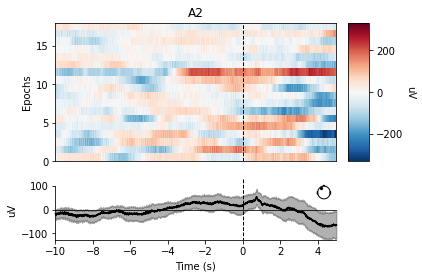

25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


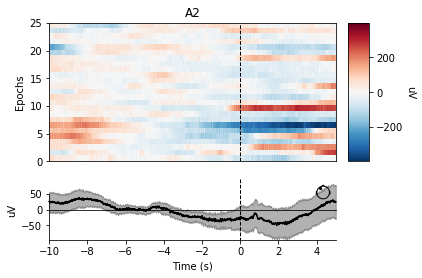

In [13]:
conds = ['Response 1 (this may be a response to question 1, 2 or 3)',
                       'Response 2 (this may be a response to question 1, 2 or 3)',
                      'First question onset (most important marker)']
epochs1.equalize_event_counts(conds)
epochs15.equalize_event_counts(conds)

r1_epochs1 = epochs1['Response 1 (this may be a response to question 1, 2 or 3)']
r2_epochs1 = epochs1['Response 2 (this may be a response to question 1, 2 or 3)']
onset_epochs1 = epochs1['First question onset (most important marker)']
onset_epochs1.plot_image(picks=['A2']);

r1_epochs15 = epochs15['Response 1 (this may be a response to question 1, 2 or 3)']
r2_epochs15 = epochs15['Response 2 (this may be a response to question 1, 2 or 3)']
onset_epochs15 = epochs15['First question onset (most important marker)']
onset_epochs15.plot_image(picks=['A2']);

We can see that there was an interesting dip around the onset for our expert mediator (second plot), but some hill for the non-expert (first plot). It may be related to mind wandering episodes that the non-expert may be invoking executive functions in the prefrontal cortex. It also seems that there are a totally inverse relationship for this channel. 

Let's try another channel, `B17`, located by the parietal lobe.

18 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


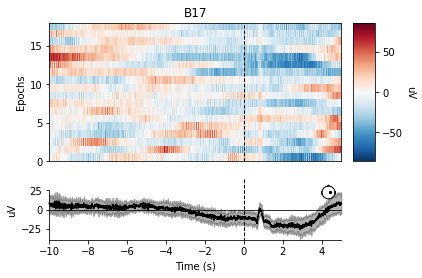

25 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


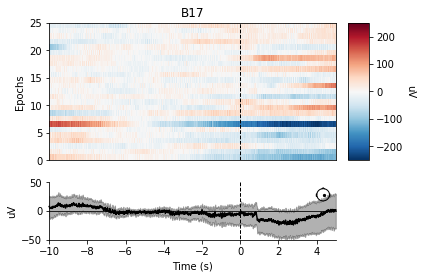

In [14]:
onset_epochs1.plot_image(picks=['B17']);
onset_epochs15.plot_image(picks=['B17']);

`B17` is located in parieital lobe, and many research had found that this region have activity correlated with the default-mode network and overall functional connectivity of the brain. As you can see, the 2 subjects actually display similar pattern for the meditation, but a clear spike of activity in the non-expert (first plot) around the first second right after the onset of interruption. We can also see a greater variability in activities before the onset. Does this tell us about the more "smooth" brain activity, even in response to interruption, for expert meditators?

#### Time Frequency Analysis
Since channel `B17` seem to be showing some interesting stuff, let's run a time frequency analysis for both subjects at this channel.

No baseline correction applied


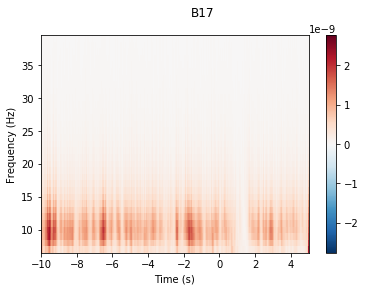

No baseline correction applied


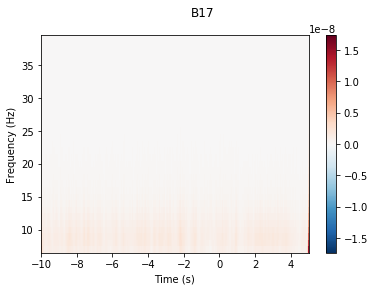

In [15]:
frequencies = np.arange(7, 40, 1)
power1 = mne.time_frequency.tfr_morlet(onset_epochs1, n_cycles=3, return_itc=False,
                                      freqs=frequencies, decim=3)
power15 = mne.time_frequency.tfr_morlet(onset_epochs15, n_cycles=3, return_itc=False,
                                      freqs=frequencies, decim=3)
power1.plot(['B17']);
power15.plot(['B17']);

Well, it doesn't tell us much, but does confirm what we had discussed earlier. It seems that there's more variability in activity for the non-expert (first plot) than the expert (second plot) at channel `B17`.

#### Evoked Response

Since this is an event related, we can take a look at the evoked response between the 2 subjects around the onset of the interruption. We only looked at 2 individual channels earlier, but we can also look at the aggregated response from all channels for these 2 subjects

combining channels using "gfp"
combining channels using "gfp"


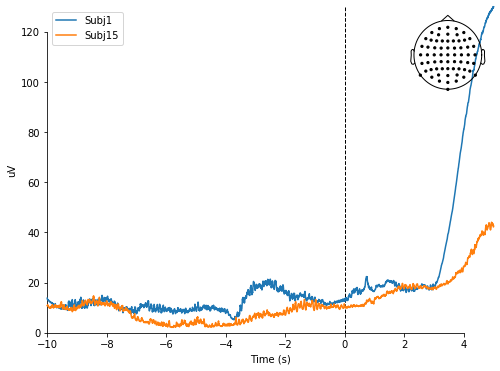

In [16]:
onset_evoked1 = onset_epochs1.average()
onset_evoked15 = onset_epochs15.average()

mne.viz.plot_compare_evokeds(dict(Subj1=onset_evoked1, Subj15=onset_evoked15),
                             legend='upper left', show_sensors='upper right');

It seems that even from the aggregated results we can tell which person is an expert and who is non-expert. There is a huge amount of variability for Subject 1 (blue line), while Subject 15's activities seemed to be relatively smooth overall. The spike around 3 seconds after onset (presumably when questions kick in) are drastically different as well.

Given all of the results found here around the onset epoches, we are more motivated to see whether this could be trained as a classifer to label the level of experience for a meditator. With this graph, it's quite convincing that it will work.

### Data Cleaning
For simplicity of the final output, data cleaning is performed via the notebook `data_cleaning.ipynb` in the same `notebooks` folder. A `*.csv` export of the clean up data will be used and loaded here. 

This is going to take a while load. Good time to a tea break. Come back in a minute.

In [17]:
cleaned = pd.read_csv('../final_data.csv')

### Data Analysis
#### Separating Data: X, Y, Train, Validation, Test
We will be separating the data into 80% of epoches as training set, 20% of epoches as test set. We will use Cross Validation within as we train, using another 80-20 split. 

In [22]:
# Setting Random Seed
np.random.seed(45)

# Partitioning X matrix and y vector
X = cleaned.drop('expert', axis=1)
y = cleaned['expert']

# Splitting into Train and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Correlation Matrix
Let's take a look at which channels are most correlated with each other.

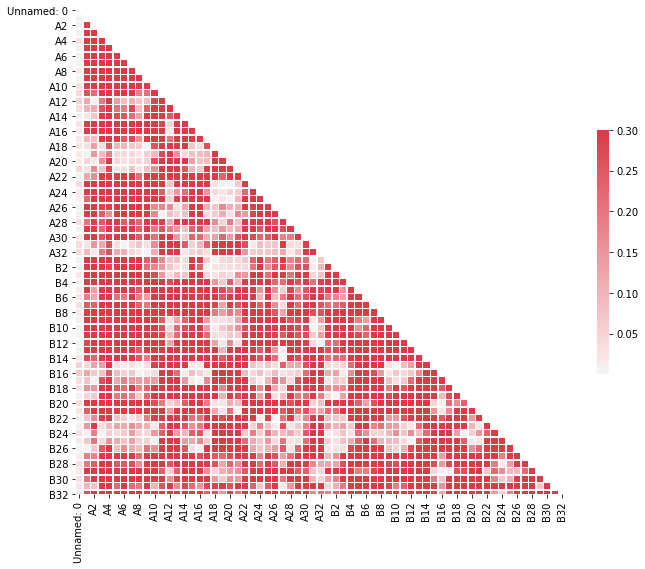

In [32]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It seems that a lot of these regions are loosely correlated with each other, but not a lot. There are several channels that are completely not related (lighter areas), say `B17` and `A2`, which were the 2 we discussed earlier, being in completely different regions of the brain (parietal vs. frontal).

#### Independent Component Analysis (ICA)
Let's run ICA on our `X_train` and see what features stand out.

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
ica = FastICA(n_components=10) # 10 independent components
X_train_transformed = ica.fit_transform(X_train)

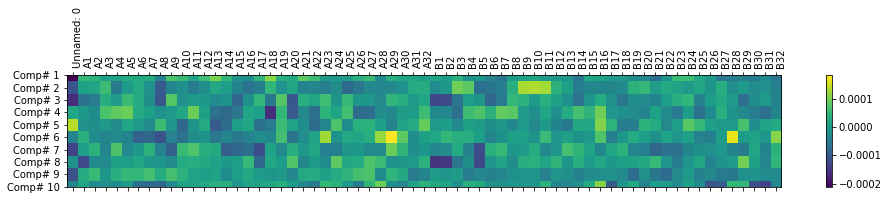

In [61]:
plt.figure(figsize=(16,2))
plt.matshow(ica.components_, cmap='viridis', fignum=1, aspect='auto')
labs = []
plt.yticks(range(ica.components_.shape[0]), 
           [f'Comp# {i}' for i in range(1, ica.components_.shape[0]+11)],fontsize=10)
plt.colorbar()
plt.xticks(range(ica.components_.shape[1]), np.array(X.columns),rotation=90,ha='left')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.show();

This ICA component matrix tells us that there are seveal channels of higher importances, even though with a very limited amount of variances explained. It does seem that time has something to do with the components as well.

#### Principal Component Analysis (PCA)
We will try running PCA and see if any matching channels would show up from our results.

In [54]:
pca = PCA(n_components=.95) # 95% variance explained
X_train_transformed = pca.fit_transform(X_train)

NameError: name 'pca_components_' is not defined

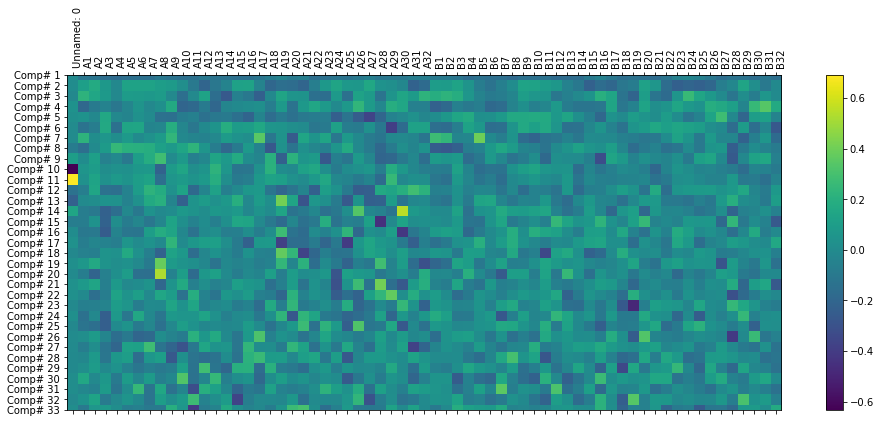

In [60]:
plt.figure(figsize=(16,6))
plt.matshow(pca.components_, cmap='viridis', fignum=1, aspect='auto')
labs = []
plt.yticks(range(pca.components_.shape[0]), 
           [f'Comp# {i}' for i in range(1, pca.components_.shape[0]+1)],fontsize=10)
plt.colorbar()
plt.xticks(range(pca.components_.shape[1]), np.array(X.columns),rotation=90,ha='left')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.show();

The PCA yielded a total of 33 principal components and it seems that there are quiet a few channels highly related to some PCs. It seems that time is a huge factor for PC #10 and #11.

____
<center><b>Please note the the following analyses will take quite some time to run. It's time for a meal break, I'd say! The last 2 methods will probably take 30 minutes to an hour to run.</b></center>

____

#### Logistic Regression (L-BFGS) with 5-Fold Cross Validation
We can now try to run a simple logistic regression model to predict the labels in the y-vector.

In [65]:
# Create Logistic Function
logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)  

# Cross Validation
cross_val_score(logistic, X_train, y_train, cv=5)

array([0.54178606, 0.54268821, 0.54252523, 0.54246067, 0.54301355])

Our logistic regression using L-BFGS solver yielded a 54% accuracy for our model.

#### Logistic Regression (LASSO) with 5-Fold Cross Validation
We will introduce a L1 penalty and see if our result improves.

In [66]:
# Create Logistic Function with L1 Penalty
logistic_l1 = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=500)  

# Cross Validation
cross_val_score(logistic_l1, X_train, y_train, cv=5)

array([0.54177778, 0.5427031 , 0.5425484 , 0.54246398, 0.54300858])

This yielded similar results for a 54% accuracy.... It's bad, but at least it's slightly better than chance (50%).

#### Neural Network: Multi-Layer Perceptron classifier
We will deply an MLP classifier to see if our result will improve.

In [71]:
mlp = MLPClassifier(activation='logistic')
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [72]:
mlp.score(X_train, y_train)

0.9932168252133212

In [74]:
mlp.score(X_test, y_test)

0.5357992745725633

It appears that our neural network is really bad at overfitting and yielded something of 99% accuracy on our training set (!!!!!), but ~54% on our test set... That's not good!

Let's see if random forest performs a little better.

#### Random Forest
We will now deploy a random forest on our data to see how well we did. 

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, 
                       index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.figure(figsize=(50, 80))
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show();

## Discussion
xx

## References
**Berkovich-Ohana, A., Harel, M., Hahamy, A., Arieli, A., Malach, R. (2016).** Data for default network reduced functional connectivity in meditators, negatively correlated with meditation expertise. *Data Brief* 8:910–914

**Brandmeyer, T. & Delorme, A. (2018).** Reduced mind wandering in experienced meditators and associated EEG correlates. *Exp Brain Res* 236: 2519.

**Christoff, K., Gordon, A.M., Smallwood, J., Smith, R., Schooler, J.W. (2009).** Experience sampling during fMRI reveals default network and executive system contributions to mind wandering. *Proc Natl Acad Sci* 106(21):8719–8724

**Delorme, A. (2018).** BIDS formatted EEG meditation experiment data (Version 2.0) [Data set]. *Zenodo*. http://doi.org/10.5281/zenodo.2536267

**Garrison, K.A., Zeffiro, T.A., Scheinost, D., Constable, R.T., Brewer, J.A.. (2015).** Meditation leads to reduced default mode network activity beyond an active task. *Cogn Affect Behav Neurosci* 15(3):712–720


## Footnotes/Comments

1. Many of these codes are adopted from the `mne` package's examples and tutorials, as well as from the documentation of `scikit-learn` and `seaborn`.
1. See Appendix A (`data_cleaning.ipynb`) in the `notebooks` folder for the data cleaning steps.
1. This project took about 20 hours from beginning to end, concentrated on 3-4 days over the span of a month. Since I had zero prior knowledge of working with brain data in general and EEG specifically, the bulk of the time (~10 hours) was me mindlessly learning how to actually process the EEG data using the `mne` package, and figuring out the custom montage from scratch. Running the more advanced